In [8]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)


In [9]:
# Load function (robust to header quotes and label formatting)
def load_csv_pure_python(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    feature_names = [x.strip('"') for x in lines[0].strip().split(",")][:-1]
    X = []
    y = []
    for line in lines[1:]:
        line = line.strip()
        if not line:  # skip empty lines
            continue
        parts = line.split(",")
        X.append([float(x) for x in parts[:-1]])
        y.append(int(parts[-1].strip(' "')))
    return np.array(X, dtype=np.float64), np.array(y, dtype=np.int32), feature_names


X, y, feature_names = load_csv_pure_python("../data/creditcard.csv")


# Mimic df.head()
def head(X, y, feature_names, n=5):
    print(f"First {n} entries with features and label:")
    for i in range(min(n, len(y))):
        features_str = ", ".join(
            [f"{feature_names[j]}: {X[i, j]:.4f}" for j in range(len(feature_names))]
        )
        print(f"Entry {i + 1}: {features_str} | Label: {y[i]}")


head(X, y, feature_names, 5)


First 5 entries with features and label:
Entry 1: Time: 0.0000, V1: -1.3598, V2: -0.0728, V3: 2.5363, V4: 1.3782, V5: -0.3383, V6: 0.4624, V7: 0.2396, V8: 0.0987, V9: 0.3638, V10: 0.0908, V11: -0.5516, V12: -0.6178, V13: -0.9914, V14: -0.3112, V15: 1.4682, V16: -0.4704, V17: 0.2080, V18: 0.0258, V19: 0.4040, V20: 0.2514, V21: -0.0183, V22: 0.2778, V23: -0.1105, V24: 0.0669, V25: 0.1285, V26: -0.1891, V27: 0.1336, V28: -0.0211, Amount: 149.6200 | Label: 0
Entry 2: Time: 0.0000, V1: 1.1919, V2: 0.2662, V3: 0.1665, V4: 0.4482, V5: 0.0600, V6: -0.0824, V7: -0.0788, V8: 0.0851, V9: -0.2554, V10: -0.1670, V11: 1.6127, V12: 1.0652, V13: 0.4891, V14: -0.1438, V15: 0.6356, V16: 0.4639, V17: -0.1148, V18: -0.1834, V19: -0.1458, V20: -0.0691, V21: -0.2258, V22: -0.6387, V23: 0.1013, V24: -0.3398, V25: 0.1672, V26: 0.1259, V27: -0.0090, V28: 0.0147, Amount: 2.6900 | Label: 0
Entry 3: Time: 1.0000, V1: -1.3584, V2: -1.3402, V3: 1.7732, V4: 0.3798, V5: -0.5032, V6: 1.8005, V7: 0.7915, V8: 0.2477, V9

In [10]:
# Cell 3: Preprocessing including missing value handling and complete standardization


def check_missing_values(X):
    missing_count = np.sum(np.isnan(X))
    print(f"Total missing values in dataset: {missing_count}")
    return missing_count


def impute_missing_values(X):
    for col in range(X.shape[1]):
        col_data = X[:, col]
        mask = np.isnan(col_data)
        if np.any(mask):
            mean_val = np.nanmean(col_data)
            col_data[mask] = mean_val
            X[:, col] = col_data
    return X


def standardize_all(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0) + 1e-8
    return (X - mean) / std


def train_val_split(X, y, val_ratio=0.2):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    split = int(len(y) * (1 - val_ratio))
    train_idx = indices[:split]
    val_idx = indices[split:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


print("Checking for missing values...")
missing_vals = check_missing_values(X)
if missing_vals > 0:
    X = impute_missing_values(X)
    print("Missing values imputed")

X = standardize_all(X)
print("All features standardized.")

X_train, y_train, X_val, y_val = train_val_split(X, y, val_ratio=0.2)
print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}")

print("Class distribution in training set:")
print(Counter(y_train))


Checking for missing values...
Total missing values in dataset: 0
All features standardized.
Train size: 227845, Validation size: 56962
Class distribution in training set:
Counter({np.int32(0): 227458, np.int32(1): 387})


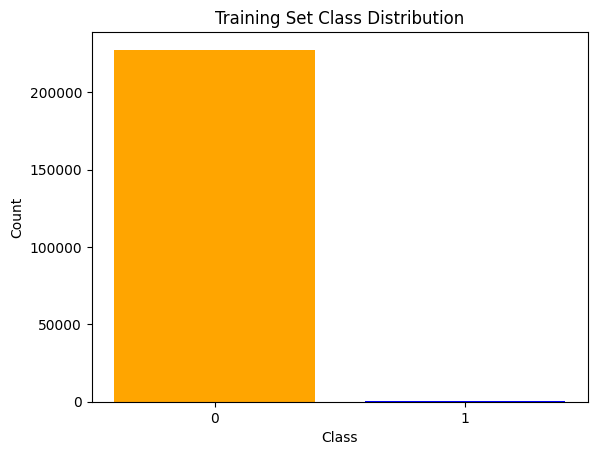

In [11]:
# Cell 4: Plot class distribution


def plot_class_distribution(y, title="Class Distribution"):
    counter = Counter(y)
    classes = list(counter.keys())
    counts = [counter[c] for c in classes]
    plt.bar(classes, counts, color=["blue", "orange"])
    plt.xticks(classes)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()


plot_class_distribution(y_train, title="Training Set Class Distribution")


In [12]:
# Cell 5: Logistic Regression model with weighted loss for imbalance


class LogisticRegressionScratch:
    def __init__(self, n_features, lr=0.01, epochs=100, reg_lambda=0.0, pos_weight=1.0):
        self.lr = lr
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.pos_weight = pos_weight
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0
        self.loss_history = []
        self.val_loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(np.int32)

    def binary_cross_entropy(self, y_true, y_pred):
        eps = 1e-8
        weights = np.where(y_true == 1, self.pos_weight, 1.0)
        loss = -np.mean(
            weights
            * (y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
        )
        loss += self.reg_lambda * np.sum(self.w**2)
        return loss

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n = len(y_train)
        weights = np.where(y_train == 1, self.pos_weight, 1.0)
        for epoch in range(self.epochs):
            y_pred = self.predict_proba(X_train)
            error = (y_pred - y_train) * weights
            dw = np.dot(X_train.T, error) / n + 2 * self.reg_lambda * self.w
            db = np.mean(error)

            self.w -= self.lr * dw
            self.b -= self.lr * db

            train_loss = self.binary_cross_entropy(y_train, y_pred)
            self.loss_history.append(train_loss)

            if X_val is not None and y_val is not None:
                val_pred = self.predict_proba(X_val)
                val_loss = self.binary_cross_entropy(y_val, val_pred)
                self.val_loss_history.append(val_loss)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                if X_val is not None:
                    print(
                        f"Epoch {epoch + 1:3d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}"
                    )
                else:
                    print(f"Epoch {epoch + 1:3d}: Train Loss={train_loss:.4f}")


In [ ]:
# Cell 6: Evaluation Metrics


def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn


def precision_recall_f1(tp, tn, fp, fn):
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return precision, recall, f1, accuracy


def roc_curve(y_true, y_scores):
    thresholds = np.linspace(1, 0, 100)
    tprs, fprs = [], []
    pos = np.sum(y_true)
    neg = len(y_true) - pos
    for t in thresholds:
        preds = (y_scores >= t).astype(np.int32)
        tp = np.sum((y_true == 1) & (preds == 1))
        fp = np.sum((y_true == 0) & (preds == 1))
        tprs.append(tp / (pos + 1e-8))
        fprs.append(fp / (neg + 1e-8))
    return np.array(fprs), np.array(tprs)


def roc_auc_score(y_true, y_scores):
    fpr, tpr = roc_curve(y_true, y_scores)
    return np.trapz(tpr, fpr)  # Numerical integration for AUC


In [14]:
# Cell 7: Matplotlib Visualizations


def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(tp, tn, fp, fn):
    matrix = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    thresh = matrix.max() / 2
    for i in range(2):
        for j in range(2):
            ax.text(
                j,
                i,
                matrix[i, j],
                ha="center",
                va="center",
                color="white" if matrix[i, j] > thresh else "black",
            )
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, lw=2, color="darkorange", label=f"ROC curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


Positive class weight: 587.75
Epoch   1: Train Loss=1.3840, Val Loss=0.9886
Epoch  10: Train Loss=0.8598, Val Loss=0.8345
Epoch  20: Train Loss=0.8123, Val Loss=0.7891
Epoch  30: Train Loss=0.7819, Val Loss=0.7600
Epoch  40: Train Loss=0.7578, Val Loss=0.7368
Epoch  50: Train Loss=0.7371, Val Loss=0.7168
Epoch  60: Train Loss=0.7186, Val Loss=0.6988
Epoch  70: Train Loss=0.7017, Val Loss=0.6824
Epoch  80: Train Loss=0.6861, Val Loss=0.6671
Epoch  90: Train Loss=0.6716, Val Loss=0.6529
Epoch 100: Train Loss=0.6579, Val Loss=0.6396
Optimal threshold for max F1: 0.95 (F1=0.8309)

Final evaluation on validation set:
Accuracy:  0.9994
Precision: 0.8431
Recall:    0.8190
F1-score:  0.8309
ROC AUC:   0.9804


C:\Users\harsh\AppData\Local\Temp\ipykernel_6908\225204438.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)  # Numerical integration for AUC


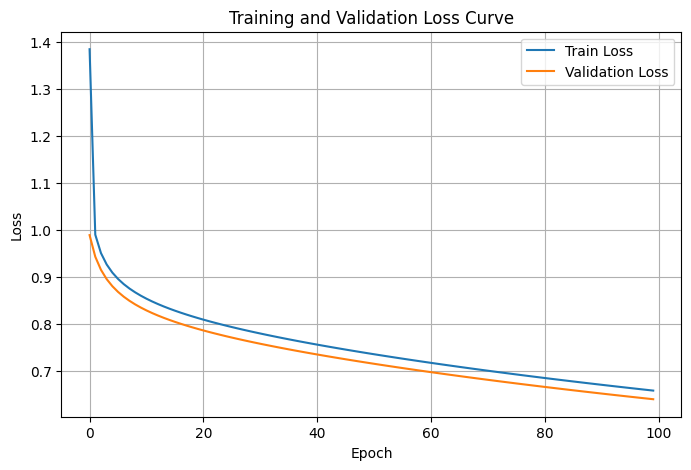

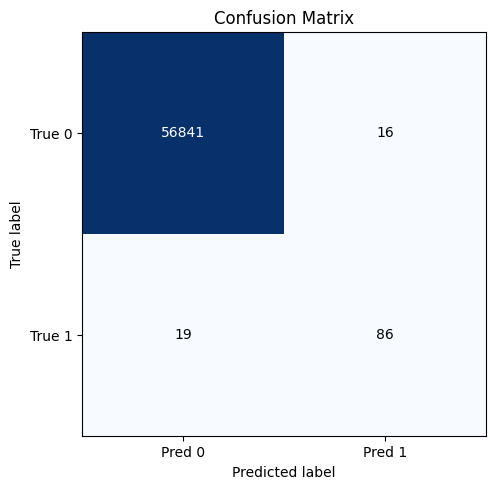

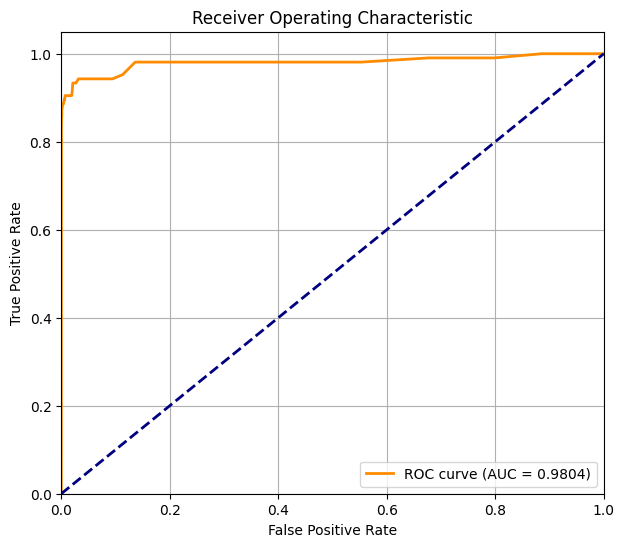

In [ ]:
# Cell 8: Train, Tune Threshold, Evaluate, and Plot

pos_weight = (len(y_train) - np.sum(y_train)) / (np.sum(y_train) + 1e-8)
print(f"Positive class weight: {pos_weight:.2f}")

model = LogisticRegressionScratch(
    n_features=X_train.shape[1],
    lr=0.01,
    epochs=100,
    reg_lambda=0.01,
    pos_weight=pos_weight,
)

model.fit(X_train, y_train, X_val, y_val)

y_scores = model.predict_proba(X_val)


# Threshold tuning to maximize F1
def best_threshold_by_f1(y_true, y_scores):
    best_t, best_f1 = 0.5, 0
    for t in np.linspace(0.01, 0.99, 99):
        preds = (y_scores >= t).astype(np.int32)
        tp, tn, fp, fn = confusion_matrix(y_true, preds)
        p, r, f1, _ = precision_recall_f1(tp, tn, fp, fn)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1


optimal_thresh, optimal_f1 = best_threshold_by_f1(y_val, y_scores)
print(f"Optimal threshold for max F1: {optimal_thresh:.2f} (F1={optimal_f1:.4f})")

# Use optimal threshold for predictions
y_pred = (y_scores >= optimal_thresh).astype(np.int32)

tp, tn, fp, fn = confusion_matrix(y_val, y_pred)
precision, recall, f1, accuracy = precision_recall_f1(tp, tn, fp, fn)
auc = roc_auc_score(y_val, y_scores)

print("\nFinal evaluation on validation set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

plot_loss_curve(model.loss_history, model.val_loss_history)
plot_confusion_matrix(tp, tn, fp, fn)
fpr, tpr = roc_curve(y_val, y_scores)
plot_roc_curve(fpr, tpr, auc)
